In [1]:
# !wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
# !wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
# !unzip -qq Flickr8k_Dataset.zip
# !unzip -qq Flickr8k_text.zip
# !rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [2]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip glove.6B.100d.txt

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from PIL import Image
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
import tensorflow as tf
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, Dense, Embedding, GRU , Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from numpy.linalg import norm

In [4]:
# captions_file = '/content/Flickr8k.token.txt'
# photos_dir = '/content/Flicker8k_Dataset'
# resized_dir = '/content/resized_images'

captions_file = r'C:\Users\Essam\Desktop\Deep Learning Assignment\Flickr8k_text\Flickr8k.token.txt'
photos_dir = r'C:\Users\Essam\Desktop\Deep Learning Assignment\Flickr8k_Dataset\Flicker8k_Dataset'
resized_dir = r'C:\Users\Essam\Desktop\Deep Learning Assignment\resized_images'


captions_dict = {}
with open(captions_file, 'r') as file:
    for line in file:
        photo, caption = line.strip().split('\t')
        photo_id = photo.split('#')[0]
        captions_dict.setdefault(photo_id, []).append(caption.strip())

rows = []
for photo, captions in captions_dict.items():
    for caption in captions[:3]:
        rows.append((photo, caption))

data = pd.DataFrame(rows, columns=["ID", "Caption"])

def preprocess_caption(caption):
    tokens = simple_preprocess(caption)
    return ' '.join([word for word in tokens if len(word) > 1])

data["Caption"] = data["Caption"].apply(preprocess_caption)

unique_photos = list(captions_dict.keys())
train_ids, test_ids = train_test_split(unique_photos, test_size=0.02, random_state=42)

train_data = data[data["ID"].isin(train_ids)].reset_index(drop=True)
test_data = data[data["ID"].isin(test_ids)].reset_index(drop=True)


train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)

train_data['Caption_end'] = train_data["Caption"].apply(lambda cap:  cap + " <end>")
train_data['Caption'] = train_data["Caption"].apply(lambda cap: "<start> " + cap)


test_data["Caption_end"] = test_data["Caption"].apply(lambda x: x + " <end>")

os.makedirs(resized_dir, exist_ok=True)

print("Train shape:",train_data.shape)
print("Test shape:", test_data.shape)

Train shape: (23790, 3)
Test shape: (486, 3)


In [5]:
train_data

,ID,Caption,Caption_end
0,2938120171_970564e3d8.jpg,<start> two dogs are standing together on patio,two dogs are standing together on patio <end>
1,2898304260_a4099a193a.jpg,<start> skateboarder hits curve at the top of ...,skateboarder hits curve at the top of the skat...
2,3728015645_b43a60258b.jpg,<start> skateboarder wearing white cap is doin...,skateboarder wearing white cap is doing stunt ...
3,3352199368_b35f25793e.jpg,<start> man in black carrying an orange backpa...,man in black carrying an orange backpack stand...
4,229951087_4c20600c32.jpg,<start> man paddles canoe in lake,man paddles canoe in lake <end>
...,...,...,...
23785,453756106_711c20471a.jpg,<start> small dog and large dog play together,small dog and large dog play together <end>
23786,2419591925_1038c6c570.jpg,<start> little boy climbing over chain fence,little boy climbing over chain fence <end>
23787,1319634306_816f21677f.jpg,<start> large tan dog sits on grassy hill,large tan dog sits on grassy hill <end>
23788,3385246141_a263d1053e.jpg,<start> camera man videotapes skier climbing t...,camera man videotapes skier climbing tree stum...


In [ ]:
test_data

,ID,Caption,Caption_end
0,109823397_e35154645f.jpg,man jumps gin the air while riding an atv,man jumps gin the air while riding an atv <end>
1,109823397_e35154645f.jpg,man on four wheeler jumps near small building,man on four wheeler jumps near small building ...
2,109823397_e35154645f.jpg,an atv is airborne over field in front of whit...,an atv is airborne over field in front of whit...
3,1112212364_0c48235fc2.jpg,baby is sitting on and playing with smooth rocks,baby is sitting on and playing with smooth roc...
4,1112212364_0c48235fc2.jpg,baby is stacking rocks on the beach,baby is stacking rocks on the beach <end>
...,...,...,...
481,883040210_3c4a10f030.jpg,person hangs from safety rope as he climbs dow...,person hangs from safety rope as he climbs dow...
482,883040210_3c4a10f030.jpg,person is abseiling down rock face attached to...,person is abseiling down rock face attached to...
483,95728660_d47de66544.jpg,guy is riding bike up the side of hill,guy is riding bike up the side of hill <end>
484,95728660_d47de66544.jpg,young man bicycles towards the camera and away...,young man bicycles towards the camera and away...


In [7]:
def resize_and_save_images(source_dir, target_dir, target_size=(224, 224)):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    needed_images = set(train_data['ID'].tolist() + test_data['ID'].tolist())

    print("Starting image preprocessing...")
    print(f"Need to process {len(needed_images)} images")

    for i, img_name in enumerate(needed_images):
        source_path = os.path.join(source_dir, img_name)
        target_path = os.path.join(target_dir, img_name)

        if os.path.exists(target_path):
            continue

        try:
            img = Image.open(source_path)
            img = img.resize(target_size, Image.Resampling.LANCZOS)
            img.save(target_path)

            if (i + 1) % 100 == 0:
                print(f"Processed {i + 1} images")

        except Exception as e:
            print(f"Error processing {img_name}: {str(e)}")

    print("Image preprocessing complete!")

resize_and_save_images(
    source_dir=photos_dir,
    target_dir=resized_dir
)

Starting image preprocessing...
Need to process 8092 images
Error processing 2258277193_586949ec62.jpg.1: [Errno 2] No such file or directory: 'C:\\Users\\Essam\\Desktop\\Deep Learning Assignment\\Flickr8k_Dataset\\Flicker8k_Dataset\\2258277193_586949ec62.jpg.1'
Image preprocessing complete!


In [8]:
tokenizer = Tokenizer(oov_token="<OOV>", filters='')
tokenizer.fit_on_texts(train_data["Caption"].tolist() + train_data["Caption_end"].tolist())

tokenizer.word_index["<pad>"] = 0
tokenizer.index_word[0] = "<pad>"

max_len= max([len(caption.split()) for caption in train_data["Caption"].tolist()])

word_index = tokenizer.word_index
vocab_size = len(word_index)

In [9]:
vocab_size

6838

In [ ]:
class ImageCaptioningDataGenerator(Sequence):
    def __init__(
        self,
        data,
        tokenizer,
        batch_size,
        max_len,
        image_dir,
        shuffle: bool = True,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.data = data
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_len = max_len
        self.image_dir = image_dir
        self.shuffle = shuffle
        self.num_samples = len(self.data)
        self.on_epoch_end()


    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, input_seqs, target_seqs = [], [], []
        for i in batch_indexes:
            row = self.data.iloc[i]
            image_id = str(row["ID"])

            if image_id.endswith('.1'):
                continue

            img_path = os.path.join(self.image_dir, image_id)
            try:
                img = load_img(img_path, target_size=(224, 224))
            except FileNotFoundError:
                 print(f"Warning: File not found, skipping: {img_path}")
                 continue

            img = img_to_array(img)
            img = preprocess_input(img)
            images.append(img)
            
            inp = self.tokenizer.texts_to_sequences([row["Caption"]])[0]
            tgt = self.tokenizer.texts_to_sequences([row["Caption_end"]])[0]

            inp = pad_sequences([inp], maxlen=self.max_len, padding='post')[0]
            tgt = pad_sequences([tgt], maxlen=self.max_len, padding='post')[0]

            input_seqs.append(inp)
            target_seqs.append(tgt)

        if not images:
            return (np.empty((0, 224, 224, 3)), np.empty((0, self.max_len))), np.empty((0, self.max_len))

        return (np.stack(images, axis=0), np.stack(input_seqs, axis=0)), np.stack(target_seqs, axis=0)



train_generator = ImageCaptioningDataGenerator(
    data=train_data,
    tokenizer=tokenizer,
    batch_size=32,
    max_len=max_len,
    image_dir=resized_dir,
    shuffle=False
)

In [11]:
embeddings_index = {}

with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors.")

Loaded 400000 word vectors.


In [12]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [ ]:
# --- Encoder ---
resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in resnet_base.layers:
    layer.trainable = False

unfreeze_from_layer = "conv5_block1_out"
set_trainable = False
for layer in resnet_base.layers:
    if layer.name == unfreeze_from_layer:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

image_input = Input(shape=(224, 224, 3), name="image_input")
resnet_features = resnet_base(image_input, training=False)


pooled_features = tf.keras.layers.GlobalAveragePooling2D()(resnet_features)

image_features = Dense(1024, activation='relu', name='image_dense')(pooled_features)

# --- Decoder ---
caption_input = Input(shape=(max_len,), name="caption_input")

embedding = Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim,
                      weights=[embedding_matrix],
                      input_length=max_len,
                      trainable=True,
                      mask_zero=True,
                      name="embedding")(caption_input)

gru_output = GRU(1024, return_sequences=True, name="decoder_gru1")(embedding, initial_state=image_features)
gru_output = Dropout(0.3)(gru_output)

d_output = Dense(1024, name="decoder_d")(gru_output)
gru_output = Dropout(0.3)(gru_output)

output = Dense(vocab_size, activation='softmax', name="decoder_output")(d_output)

fine_tuned_model = Model(inputs=[image_input, caption_input], outputs=output,name="fine_tuned_model")

optimizer = Adam(learning_rate=1e-4)

fine_tuned_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fine_tuned_model.summary()

Model: "fine_tuned_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 7, 7, 2048)   23587712    image_input[0][0]                
__________________________________________________________________________________________________
caption_input (InputLayer)      [(None, 30)]         0                                            
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           resnet50[0][0]                   
___________________________________________________________________________________

In [14]:
history = fine_tuned_model.fit(
    train_generator,
    epochs=10
)

fine_tuned_model.save('image_captioning_model_weights_fine_tuned.h5')

Epoch 1/10
744/744 [==============================] - 144s 182ms/step - loss: 1.6410 - accuracy: 0.2176
Epoch 2/10
744/744 [==============================] - 136s 183ms/step - loss: 1.3082 - accuracy: 0.2922
Epoch 3/10
744/744 [==============================] - 138s 185ms/step - loss: 1.1686 - accuracy: 0.3293
Epoch 4/10
744/744 [==============================] - 139s 187ms/step - loss: 1.0705 - accuracy: 0.3572
Epoch 5/10
744/744 [==============================] - 140s 188ms/step - loss: 0.9925 - accuracy: 0.3805
Epoch 6/10
744/744 [==============================] - 140s 188ms/step - loss: 0.9261 - accuracy: 0.4006
Epoch 7/10
744/744 [==============================] - 140s 188ms/step - loss: 0.8701 - accuracy: 0.4189
Epoch 8/10
744/744 [==============================] - 140s 188ms/step - loss: 0.8194 - accuracy: 0.4372 - loss: 0.8 - ETA: 2s - loss:
Epoch 9/10
744/744 [==============================] - 140s 188ms/step - loss: 0.7747 - accuracy: 0.4548
Epoch 10/10
744/744 [=============

c:\Users\Essam\anaconda3\envs\tf26-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [15]:
# --- Encoder ---
resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in resnet_base.layers:
    layer.trainable = False

image_input = Input(shape=(224, 224, 3), name="image_input")
resnet_features = resnet_base(image_input, training=False)

pooled_features = tf.keras.layers.GlobalAveragePooling2D()(resnet_features)

image_features = Dense(1024, activation='relu', name='image_dense')(pooled_features)

# --- Decoder ---
caption_input = Input(shape=(max_len,), name="caption_input")

embedding = Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim,
                      weights=[embedding_matrix],
                      input_length=max_len,
                      trainable=False,
                      mask_zero=True,
                      name="embedding")(caption_input)

gru_output = GRU(1024, return_sequences=True, name="decoder_gru1")(embedding, initial_state=image_features)
gru_output = Dropout(0.3)(gru_output)

d_output = Dense(1024, name="decoder_d")(gru_output)
gru_output = Dropout(0.3)(gru_output)

output = Dense(vocab_size, activation='softmax', name="decoder_output")(d_output)

not_fine_tuned_model = Model(inputs=[image_input, caption_input], outputs=output , name="not_fine_tuned_model")

optimizer = Adam(learning_rate=1e-4)
not_fine_tuned_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

not_fine_tuned_model.summary()

Model: "not_fine_tuned_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 7, 7, 2048)   23587712    image_input[0][0]                
__________________________________________________________________________________________________
caption_input (InputLayer)      [(None, 30)]         0                                            
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           resnet50[0][0]                   
_______________________________________________________________________________

In [16]:
history = not_fine_tuned_model.fit(
    train_generator,
    epochs=10
)

not_fine_tuned_model.save('image_captioning_model_weights_not_finetuned.h5')

Epoch 1/10
744/744 [==============================] - 128s 165ms/step - loss: 1.6602 - accuracy: 0.2132
Epoch 2/10
744/744 [==============================] - 123s 166ms/step - loss: 1.3495 - accuracy: 0.2753
Epoch 3/10
744/744 [==============================] - 123s 166ms/step - loss: 1.2306 - accuracy: 0.3039
Epoch 4/10
744/744 [==============================] - 123s 166ms/step - loss: 1.1484 - accuracy: 0.3234
Epoch 5/10
744/744 [==============================] - 123s 166ms/step - loss: 1.0801 - accuracy: 0.3425
Epoch 6/10
744/744 [==============================] - 123s 166ms/step - loss: 1.0210 - accuracy: 0.3601
Epoch 7/10
744/744 [==============================] - 123s 165ms/step - loss: 0.9694 - accuracy: 0.3761
Epoch 8/10
744/744 [==============================] - 123s 165ms/step - loss: 0.9208 - accuracy: 0.3937
Epoch 9/10
744/744 [==============================] - 123s 165ms/step - loss: 0.8781 - accuracy: 0.4106
Epoch 10/10
744/744 [==============================] - 123s 165m

In [17]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = keras_image.load_img(img_path, target_size=target_size)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def generate_caption(model, tokenizer, img_path, max_len):
    img_input = preprocess_image(img_path)

    caption_seq = [tokenizer.word_index['<start>']]

    for i in range(max_len):
        seq_input = pad_sequences([caption_seq], maxlen=max_len, padding='post')
        preds = model.predict([img_input, seq_input], verbose=0)
        next_word_id = np.argmax(preds[0, i])

        if tokenizer.index_word.get(next_word_id) == '<end>':
            break

        caption_seq.append(next_word_id)

    caption_words = [tokenizer.index_word.get(idx, '') for idx in caption_seq[1:]]
    return ' '.join(caption_words)

def show_image_with_captions(img_path, real_caption, generated_caption):
    img = Image.open(img_path)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Real: {real_caption}\n\nGenerated: {generated_caption}", fontsize=12)
    plt.tight_layout()
    plt.show()

In [ ]:
def compute_bleu_score(model, tokenizer, test_data, resized_dir, max_len):
    references = []
    candidates = []
    missing = []

    for img_id, group in tqdm(test_data.groupby('ID'), desc="Computing BLEU", unit="image"):
        img_path = os.path.join(resized_dir, img_id)
        if not os.path.exists(img_path):
            missing.append(img_id)
            continue

        refs = [cap.replace('<end>', '').split() for cap in group['Caption_end']]
        try:
            cand_words = generate_caption(model, tokenizer, img_path, max_len).split()
        except Exception as e:
            print(f"Skipping {img_id} due to error: {e}")
            continue

        references.append(refs)
        candidates.append(cand_words)

    print(f"Skipped {len(missing)} missing images.")
    bleu_score = corpus_bleu(references, candidates)
    print(f'Corpus BLEU score on test set: {bleu_score:.4f}')

print("Fine-tuned model BLEU score:")
compute_bleu_score(fine_tuned_model, tokenizer, test_data, resized_dir, max_len)

print("Not fine-tuned model BLEU score:")
compute_bleu_score(not_fine_tuned_model, tokenizer, test_data, resized_dir, max_len)    

Fine-tuned model BLEU score:


Computing BLEU: 100%|██████████| 162/162 [01:39<00:00,  1.63image/s]


Skipped 0 missing images.
Corpus BLEU score on test set: 0.1141
Not fine-tuned model BLEU score:


Computing BLEU: 100%|██████████| 162/162 [01:34<00:00,  1.71image/s]

Skipped 0 missing images.
Corpus BLEU score on test set: 0.1213


In [19]:
def compute_test_loss_and_accuracy(model, tokenizer, test_data, resized_dir, max_len):

    valid_test_data = test_data[test_data['ID'].apply(
        lambda x: os.path.exists(os.path.join(resized_dir, x))
    )]

    print(f"Using {len(valid_test_data)} / {len(test_data)} test samples "
        f"(skipped {len(test_data) - len(valid_test_data)})")

    total_loss = 0.0
    total_tokens = 0
    correct_preds = 0

    for img_id, group in tqdm(valid_test_data.groupby('ID'), desc="Evaluating Loss & Accuracy", unit="image"):
        img_path = os.path.join(resized_dir, img_id)
        try:
            pred_caption = generate_caption(model, tokenizer, img_path, max_len)
        except Exception as e:
            print(f"Skipping {img_id} due to error: {e}")
            continue

        pred_tokens = tokenizer.texts_to_sequences([pred_caption])[0]
        true_tokens = tokenizer.texts_to_sequences([group['Caption_end'].iloc[0]])[0]

        pred_tokens = pad_sequences([pred_tokens], maxlen=max_len, padding='post')
        true_tokens = pad_sequences([true_tokens], maxlen=max_len, padding='post')

        logits = model.predict([preprocess_image(img_path), pred_tokens], verbose=0)
        loss = sparse_categorical_crossentropy(true_tokens, logits).numpy().sum()
        total_loss += loss
        total_tokens += len(true_tokens[0])

        pred_classes = np.argmax(logits, axis=-1)
        correct_preds += np.sum(pred_classes[0] == true_tokens[0])

    avg_loss = total_loss / total_tokens
    accuracy = correct_preds / total_tokens

    print(f"Inference Loss: {avg_loss:.4f}")
    print(f"Inference Accuracy: {accuracy:.4f}")

print("Fine-tuned model:")
compute_test_loss_and_accuracy(fine_tuned_model, tokenizer, test_data, resized_dir, max_len)

print("\nNot fine-tuned model:")
compute_test_loss_and_accuracy(not_fine_tuned_model, tokenizer, test_data, resized_dir, max_len)

Fine-tuned model:
Using 486 / 486 test samples (skipped 0)


Evaluating Loss & Accuracy: 100%|██████████| 162/162 [01:41<00:00,  1.60image/s]


Inference Loss: 8.9497
Inference Accuracy: 0.0354

Not fine-tuned model:
Using 486 / 486 test samples (skipped 0)


Evaluating Loss & Accuracy: 100%|██████████| 162/162 [01:42<00:00,  1.59image/s]

Inference Loss: 8.8255
Inference Accuracy: 0.0185


In [20]:
def compute_cosine_similarity_and_distance(model, tokenizer, test_data, resized_dir, max_len, embedding_matrix):

    def sentence_embedding(sentence, tokenizer, embedding_matrix):
        """Converts a sentence into an embedding vector."""
        tokens = sentence.replace('<start>', '').replace('<end>', '').split()
        vecs = []
        for w in tokens:
            idx = tokenizer.word_index.get(w)
            if idx and idx < embedding_matrix.shape[0]:
                vecs.append(embedding_matrix[idx])
        if not vecs:
            return np.zeros((embedding_matrix.shape[1],), dtype=np.float32)
        return np.mean(vecs, axis=0)
    
    cos_sims = []
    cos_dists = []
    
    for img_id, group in tqdm(test_data.groupby('ID'), desc="Computing similarity", unit="image"):
        img_path = os.path.join(resized_dir, img_id)
        if not os.path.exists(img_path):
            continue

        real_caption = group['Caption_end'].iloc[0]

        gen_caption = generate_caption(model, tokenizer, img_path, max_len)

        emb_real = sentence_embedding(real_caption, tokenizer, embedding_matrix)
        emb_gen = sentence_embedding(gen_caption, tokenizer, embedding_matrix)

        cos_sim = np.dot(emb_real, emb_gen) / (norm(emb_real) * norm(emb_gen) + 1e-8)
        cos_dist = 1 - cos_sim

        cos_sims.append(cos_sim)
        cos_dists.append(cos_dist)

    avg_cos_sim = np.mean(cos_sims)
    avg_cos_dist = np.mean(cos_dists)

    print(f"Average cosine similarity: {avg_cos_sim:.4f}")
    print(f"Average cosine distance:   {avg_cos_dist:.4f}")
    return cos_sims, cos_dists

print("Fine-tuned model:")
cos_sims_fine_tuned, cos_dists_fine_tuned = compute_cosine_similarity_and_distance(fine_tuned_model, tokenizer, test_data, resized_dir, max_len, embedding_matrix)
print("\nNot fine-tuned model:")
cos_sims_not_fine_tunes, cos_dists_not_fine_tuned = compute_cosine_similarity_and_distance(not_fine_tuned_model, tokenizer, test_data, resized_dir, max_len, embedding_matrix)

Fine-tuned model:


Computing similarity: 100%|██████████| 162/162 [01:31<00:00,  1.78image/s]


Average cosine similarity: 0.8823
Average cosine distance:   0.1177

Not fine-tuned model:


Computing similarity: 100%|██████████| 162/162 [01:33<00:00,  1.72image/s]

Average cosine similarity: 0.8857
Average cosine distance:   0.1143


Fine-tuned model cosine similarity distribution:


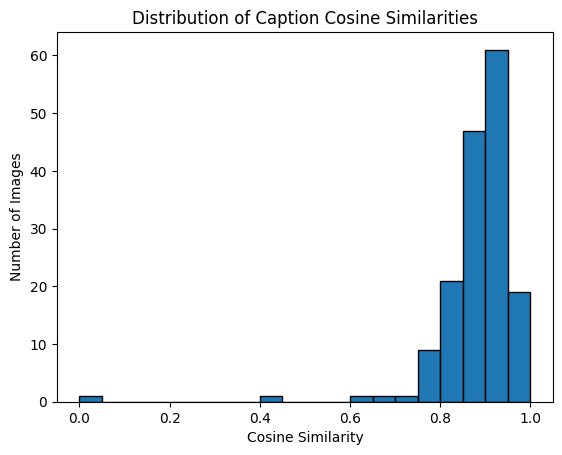


Not fine-tuned model cosine similarity distribution:


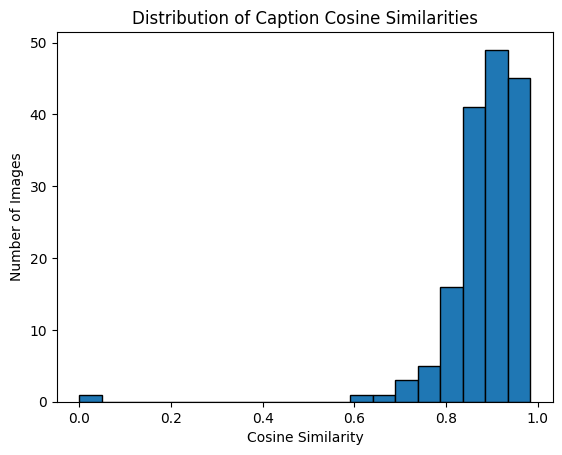

In [21]:
def plot_cosine_similarity_distribution(cos_sims):

    plt.hist(cos_sims, bins=20, edgecolor='k')
    plt.title("Distribution of Caption Cosine Similarities")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Number of Images")
    plt.show()

print("Fine-tuned model cosine similarity distribution:")
plot_cosine_similarity_distribution(cos_sims_fine_tuned)
print("\nNot fine-tuned model cosine similarity distribution:")
plot_cosine_similarity_distribution(cos_sims_not_fine_tunes)

Displaying image comparison with real caption for both models:


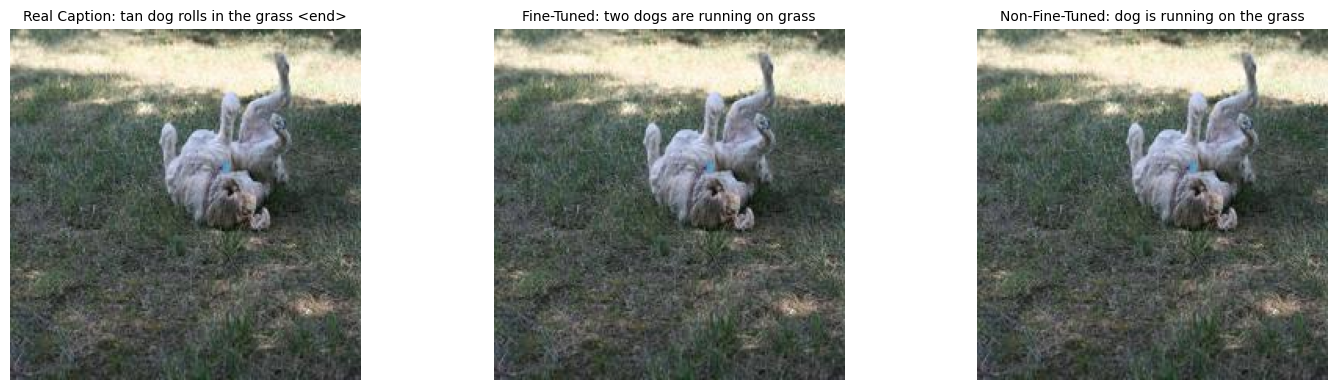

In [ ]:
def show_sample_caption_comparison_with_real(fine_tuned_model, not_fine_tuned_model, tokenizer, test_data, resized_dir, max_len):

    sample_idx = np.random.randint(0, len(test_data))
    img_filename = test_data.iloc[sample_idx]['ID']
    img_path = os.path.join(resized_dir, img_filename)

    real_caption = test_data.iloc[sample_idx]['Caption_end']

    fine_tuned_caption = generate_caption(fine_tuned_model, tokenizer, img_path, max_len)
    not_fine_tuned_caption = generate_caption(not_fine_tuned_model, tokenizer, img_path, max_len)

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    img = Image.open(img_path).convert('RGB')
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title(f"Real Caption: {real_caption}", fontsize=10)

    axs[1].imshow(img)
    axs[1].axis('off')
    axs[1].set_title(f"Fine-Tuned: {fine_tuned_caption}", fontsize=10)

    axs[2].imshow(img)
    axs[2].axis('off')
    axs[2].set_title(f"Non-Fine-Tuned: {not_fine_tuned_caption}", fontsize=10)

    plt.tight_layout()
    plt.show()

print("Displaying image comparison with real caption for both models:")
show_sample_caption_comparison_with_real(fine_tuned_model, not_fine_tuned_model, tokenizer, test_data, 'resized_images', max_len)

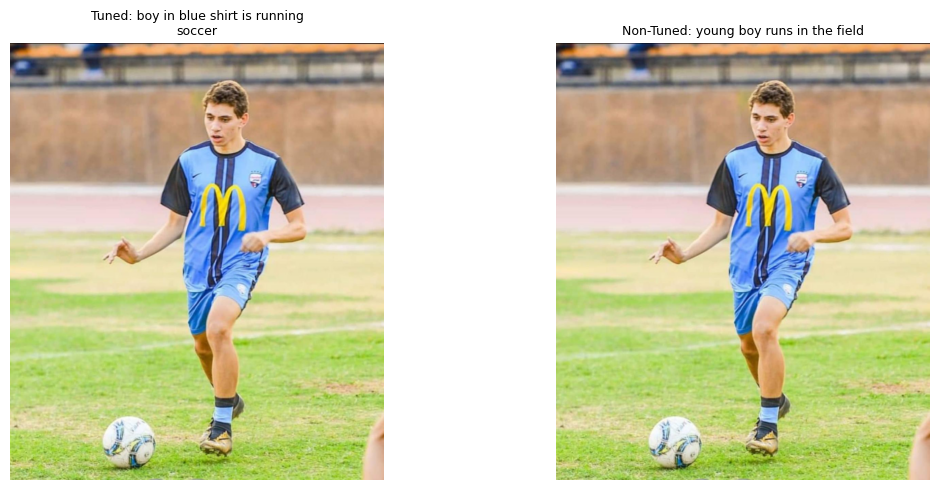

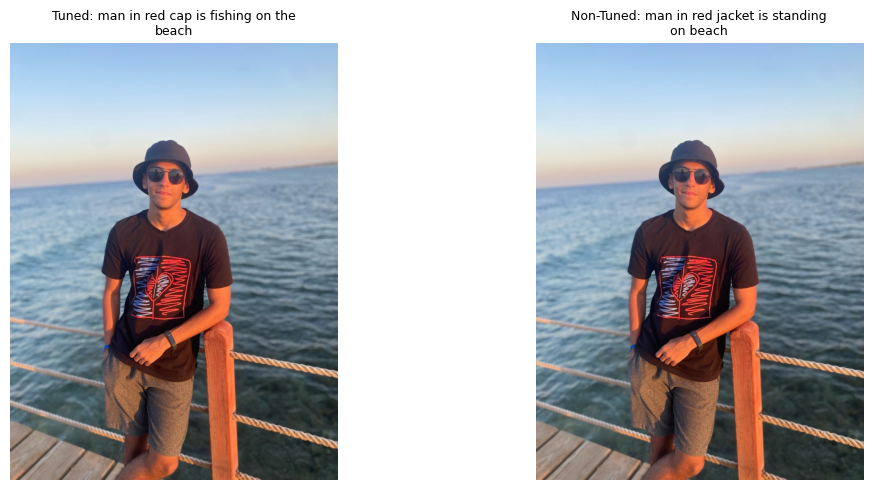

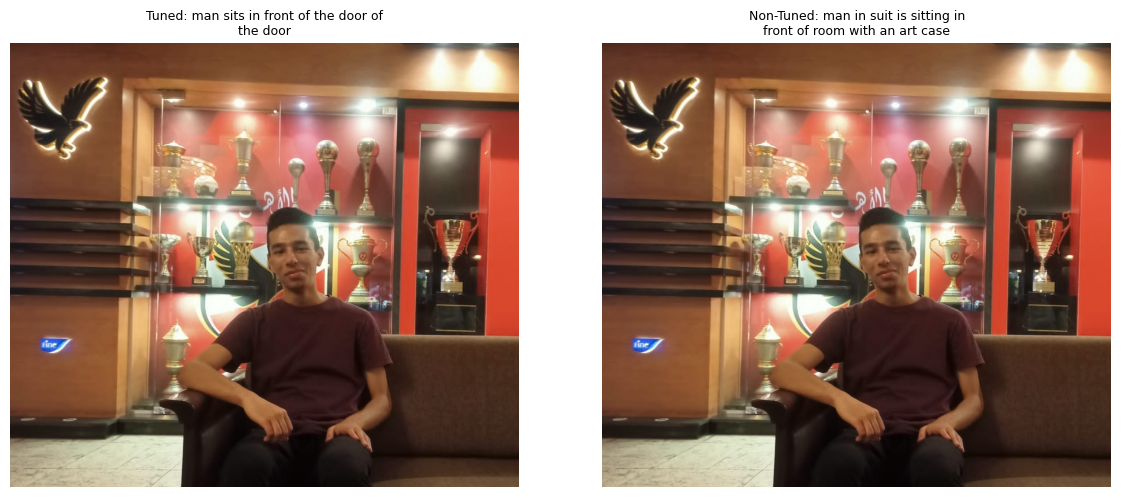

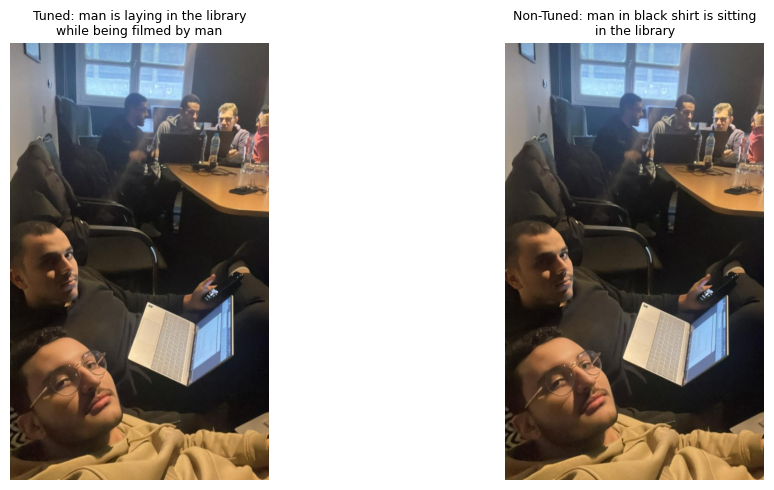

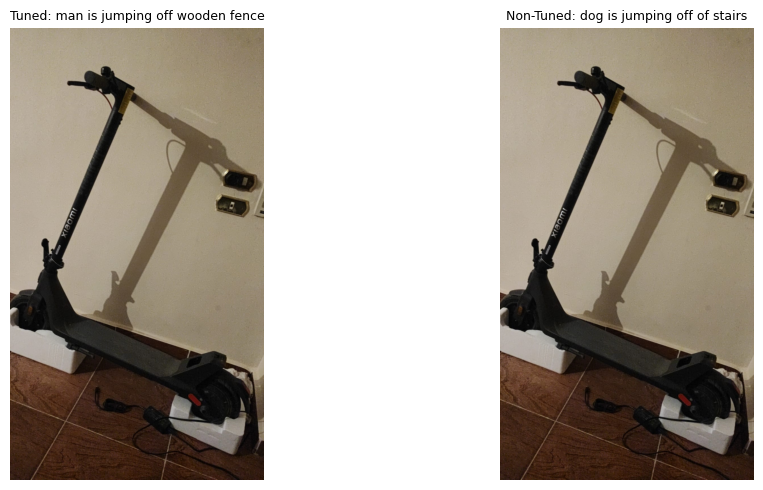

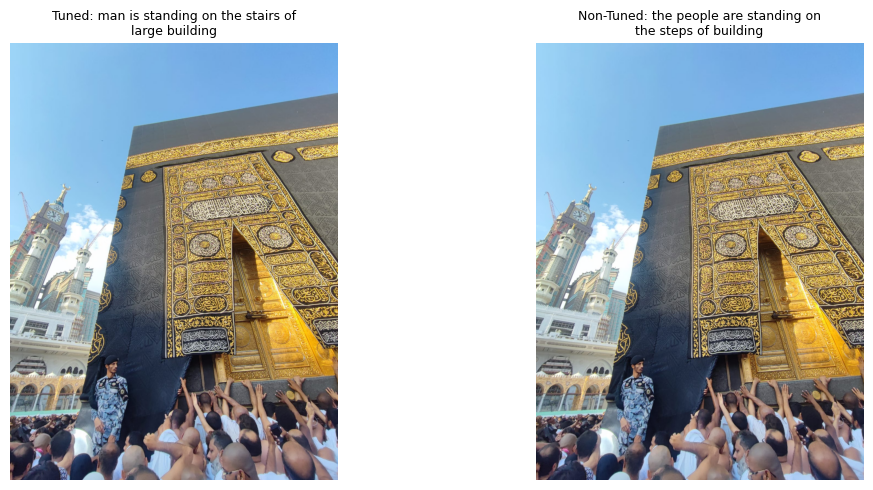

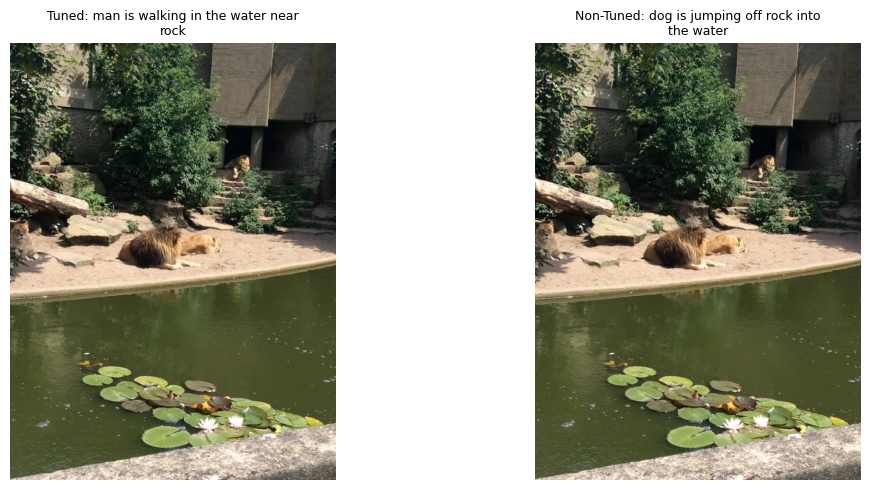

In [38]:
import os
import textwrap
from PIL import Image
import matplotlib.pyplot as plt

def display_images_with_comparative_captions(fine_tuned_model, not_fine_tuned_model, tokenizer, image_folder, max_len):
    image_files = [
        os.path.join(image_folder, fname)
        for fname in os.listdir(image_folder)
        if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

    for img_path in image_files:
        img = Image.open(img_path).convert('RGB')

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        axs[0].imshow(img)
        axs[0].axis('off')
        fine_tuned_caption = generate_caption(fine_tuned_model, tokenizer, img_path, max_len)
        wrapped_caption_tuned = "\n".join(textwrap.wrap(f"Tuned: {fine_tuned_caption}", width=40))
        axs[0].set_title(wrapped_caption_tuned, fontsize=9)

        axs[1].imshow(img)
        axs[1].axis('off')
        not_fine_tuned_caption = generate_caption(not_fine_tuned_model, tokenizer, img_path, max_len)
        wrapped_caption_not_tuned = "\n".join(textwrap.wrap(f"Non-Tuned: {not_fine_tuned_caption}", width=40))
        axs[1].set_title(wrapped_caption_not_tuned, fontsize=9)

        plt.tight_layout()
        plt.show()

IMAGE_FOLDER = r'C:\Users\Essam\Desktop\Deep Learning Assignment\sample_images/'
display_images_with_comparative_captions(fine_tuned_model, not_fine_tuned_model, tokenizer, IMAGE_FOLDER, max_len)
